# Fractions Skill Score Verification - UVV & Z - All Hazards

In [1]:
import pandas as pd
import geopandas as gpd
import xarray as xr
import xoak
import numpy as np
import matplotlib.pyplot as plt
import regionmask
import cartopy
import cartopy.crs as ccrs
import glob
%matplotlib inline
import pysteps

import warnings
warnings.filterwarnings('ignore')

Pysteps configuration file found at: /home/jcorner1/.local/lib/python3.9/site-packages/pysteps/pystepsrc



### Load the Data

In [2]:
def Data_Conv(ds):
    
    '''
    A defintion  
    
    Parameters
    ----------
    ds: xarray dataset
    
    Returns
    -------
    ds: returns a coarsened data with lat/long
    
    '''
    geog = xr.open_dataset("/home/scratch/WRF_BCC/geography/geo_em.d01.nc")
    geog = geog[['CLAT', 'CLONG']].coarsen(south_north=20, west_east=20, boundary='trim').mean()
    
    ds = ds.coarsen(south_north=20, west_east=20, boundary='trim').sum()
    ds = xr.merge([ds, geog.squeeze()])
    ds = ds.rename({"CLONG": 'lon', 'CLAT': 'lat'})

    ds = ds.assign_coords({'x': ds.west_east, 'y': ds.south_north})
    ds = ds.assign_coords({'lon': ds.lon, 'lat': ds.lat})
    ds.xoak.set_index(['lat', 'lon'], 'sklearn_geo_balltree')
    
    return ds

In [3]:
#load wrf-bcc dataset
#find all csv files for each variable and sort
files_refc = glob.glob('/home/scratch/jcorner1/syn_sev/dataframes/HIST_REFC*')
files_uvv = glob.glob('/home/scratch/jcorner1/syn_sev/dataframes/HIST_UVV*')
files_refc.sort()
files_uvv.sort()

#concat all dataframes of same variable type together
df_refc = pd.concat(map(pd.read_csv, files_refc), ignore_index=True)
df_uvv = pd.concat(map(pd.read_csv, files_uvv), ignore_index=True)

#combine the new dataframes together
df = pd.concat([df_uvv, df_refc])

#get rid of the duplicates
df = df.drop_duplicates(subset=['x','y','Time'])
df

,Unnamed: 0,x,y,Time,UH,DBZ,UVV
0,0,1137,68,1990-10-01T15:00:00.000000000,4.314072,50.534767,18.529408
1,1,1138,68,1990-10-01T16:00:00.000000000,11.310173,0.000000,21.767344
2,2,1138,69,1990-10-01T16:00:00.000000000,1.708199,0.000000,19.898508
3,3,1135,70,1990-10-01T16:00:00.000000000,2.226369,0.000000,18.301819
4,4,1136,70,1990-10-01T16:00:00.000000000,1.438110,0.000000,19.420233
...,...,...,...,...,...,...,...
50369937,3014602,909,700,2005-09-30T00:00:00.000000000,0.241252,40.251040,1.671814
50369938,3014603,908,701,2005-09-30T00:00:00.000000000,0.003803,40.213430,1.964281
50369939,3014604,919,701,2005-09-30T00:00:00.000000000,0.113389,40.785255,2.138664
50369940,3014605,920,702,2005-09-30T00:00:00.000000000,0.123360,40.707443,3.051859


In [4]:
#open dummy xarray dataset
ds = xr.open_dataset('/home/scratch/WRF_BCC/severe_weather/UP_HELI_MAX/historical/1990-1991/UP_HELI_MAX_historical-1990-1991_1990-10-01.nc')
ds = ds.sel(Time ='1990-10-01T00:00:00.000000000')
ds_copy = ds.copy()

In [5]:
#threshold the files
df_wrf = df[((df['DBZ'] >= 40.0) & (df['UVV'] >= 18.0))]
print(f'amount of rows removed from dataframe: {len(df) - len(df_wrf)}')
df_wrf

amount of rows removed from dataframe: 51812642


,Unnamed: 0,x,y,Time,UH,DBZ,UVV
0,0,1137,68,1990-10-01T15:00:00.000000000,4.314072,50.534767,18.529408
6,6,703,133,1990-10-05T17:00:00.000000000,0.691531,44.012750,19.156849
13,13,818,526,1990-10-06T07:00:00.000000000,0.000000,48.785583,19.499159
14,14,819,527,1990-10-06T07:00:00.000000000,0.000000,46.264336,19.458992
17,17,831,535,1990-10-06T08:00:00.000000000,2.502570,43.782460,18.701263
...,...,...,...,...,...,...,...
3741532,259651,695,383,2005-09-30T00:00:00.000000000,16.162450,42.275585,18.543077
3741533,259652,697,383,2005-09-30T00:00:00.000000000,12.216587,46.161420,18.107056
3741538,259657,708,384,2005-09-30T00:00:00.000000000,18.445917,40.654865,19.309635
3741544,259663,706,406,2005-09-30T00:00:00.000000000,21.218641,54.205673,18.037250


In [6]:
#create an array of zeros
zeros = np.zeros((899,1399))

#iterate through each row of the dataframe to and add one for each instance 
for rid, row in df_wrf.iterrows():
    zeros[row['y'], row['x']] = zeros[row['y'], row['x']] + 1
    
#nan all the zero values    
zeros[zeros == 0.0] = np.nan

#assign the array to the netcdf file
ds = ds_copy.assign(UP_HELI_MAX = (('south_north', 'west_east'), zeros))

#coarsen the file 
ds_cor = Data_Conv(ds)

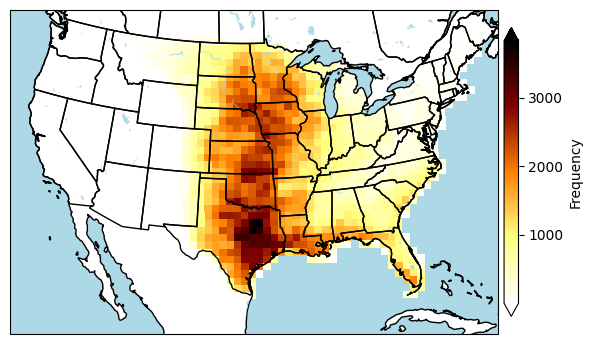

In [7]:
#Create a subplot
plt.figure(figsize=(7.5,7.5))
ax = plt.subplot(1,1,1, projection=ccrs.LambertConformal(central_longitude=-98, central_latitude=35))

#create nans for the 0 data spots
data = ds_cor.UP_HELI_MAX.values
data[data==0] = np.nan
c = ax.pcolormesh(ds_cor.lon.values, ds_cor.lat.values, data, cmap='afmhot_r', transform=cartopy.crs.PlateCarree(), vmax=int(np.nanmax(data)))

#add features to help reference map
ax.add_feature(cartopy.feature.STATES, zorder=2)
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.LAND, facecolor='white')
ax.add_feature(cartopy.feature.OCEAN, facecolor='lightblue')
ax.add_feature(cartopy.feature.LAKES, facecolor='lightblue')
ax.set_extent([-120, -74, 20, 50])

#create colorbar
cbar = plt.colorbar(c, shrink=0.5, pad=0.01, extend='both', ticks=list(range(0, int(np.nanmax(data)), 1000)), ax=ax)
cbar.ax.tick_params(labelsize=10)
cbar.set_label(label='Frequency', size=10)

In [8]:
#load the SPC reports
#NOTE: These data have been regridded to the 80-km previously
df_hail = pd.read_csv('/home/scratch/jcorner1/syn_sev/dataframes/SPC_LSRs_regridded_hail_fix.csv')
df_tor = pd.read_csv('/home/scratch/jcorner1/syn_sev/dataframes/SPC_LSRs_regridded_tor_fix.csv')
df_wind = pd.read_csv('/home/scratch/jcorner1/syn_sev/dataframes/SPC_LSRs_regridded_wind_fix.csv')

#concat the dataframes into one
df_obs = pd.concat([df_hail, df_tor, df_wind])
df_obs

,Unnamed: 0.1,Unnamed: 0,om,yr,mo,dy,date,time,tz,st,...,sn,sg,f1,f2,f3,f4,geometry,Nearest,fc,mt
0,0,47291,3560,1990,10,16,1990-10-16,17:45:00,3,TX,...,0,0,371,0,0,0,POINT (-102.68 31.23),"(787 30.997099\nName: lat, dtype: float32, ...",NaN,NaN
1,1,47292,3561,1990,10,17,1990-10-17,07:24:00,3,WI,...,0,0,47,0,0,0,POINT (-88.93 43.88),"(2114 43.597301\nName: lat, dtype: float32,...",NaN,NaN
2,2,47293,3562,1990,10,17,1990-10-17,08:35:00,3,MN,...,0,0,17,0,0,0,POINT (-92.45 46.72),"(2386 46.476452\nName: lat, dtype: float32,...",NaN,NaN
3,3,47294,3563,1990,10,17,1990-10-17,12:50:00,3,IA,...,0,0,123,0,0,0,POINT (-92.67 41.47),"(1903 41.786617\nName: lat, dtype: float32,...",NaN,NaN
4,4,47295,3564,1990,10,17,1990-10-17,13:10:00,3,IA,...,0,0,157,0,0,0,POINT (-92.42 41.58),"(1903 41.786617\nName: lat, dtype: float32,...",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149333,149333,227489,10508,2005,9,9,2005-09-09,13:15:00,3,MN,...,0,0,119,0,0,0,NaN,"(2520 47.90831\nName: lat, dtype: float32, ...",NaN,NaN
149334,149334,227490,10509,2005,9,9,2005-09-09,14:52:00,3,UT,...,0,0,37,0,0,0,NaN,"(1469 37.189175\nName: lat, dtype: float32,...",NaN,NaN
149335,149335,227491,10510,2005,9,9,2005-09-09,17:10:00,3,AZ,...,0,0,13,0,0,0,NaN,"(1121 33.566952\nName: lat, dtype: float32,...",NaN,NaN
149336,149336,227492,10511,2005,9,9,2005-09-09,18:20:00,3,AZ,...,0,0,13,0,0,0,NaN,"(1121 33.566952\nName: lat, dtype: float32,...",NaN,NaN


In [9]:
#create an array of zeros
zeros = np.zeros((ds_cor.UP_HELI_MAX.values.shape))

#iterate through each row of the dataframe to and add one for each instance
for rid, row in df_obs.iterrows():
    y1, x1 = np.where(ds_cor.lat.values == float(row.Nearest.split()[1]))
    y2, x2 = np.where(ds_cor.lon.values == float(row.Nearest.split()[7]))
    zeros[y1[0], x2[0]] = zeros[y1[0], x2[0]] + 1
    
ds_obs = ds_copy.assign(UP_HELI_MAX = (('south_north', 'west_east'), zeros))

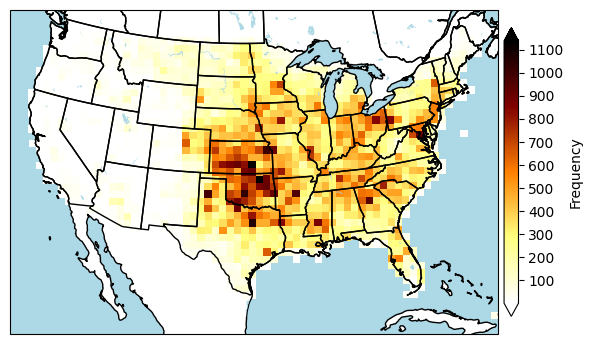

In [10]:
#Create a subplot
plt.figure(figsize=(7.5,7.5))
ax = plt.subplot(1,1,1, projection=ccrs.LambertConformal(central_longitude=-98, central_latitude=35))

#create nans for the 0 data spots
data = ds_obs.UP_HELI_MAX.values
data[data==0] = np.nan
c = ax.pcolormesh(ds_cor.lon.values, ds_cor.lat.values, data, cmap='afmhot_r', transform=cartopy.crs.PlateCarree(), vmax=int(np.nanmax(data)))

#add features to help reference map
ax.add_feature(cartopy.feature.STATES, zorder=2)
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.LAND, facecolor='white')
ax.add_feature(cartopy.feature.OCEAN, facecolor='lightblue')
ax.add_feature(cartopy.feature.LAKES, facecolor='lightblue')
ax.set_extent([-120, -74, 20, 50])

#create colorbar
cbar = plt.colorbar(c, shrink=0.5, pad=0.01, extend='both', ticks=list(range(0, int(np.nanmax(data)), 100)), ax=ax)
cbar.ax.tick_params(labelsize=10)
cbar.set_label(label='Frequency', size=10)

### Verification with FSS

In [11]:
#create a new dataframe
df = pd.DataFrame(columns=['DBZ', 'UVV', 'FSS'])

#iterate through UVV and Z values for subsetting
for refc in np.arange(40,51,5):
    for uvv in np.arange(18,25,1):
        
        #subset the dataframe based on current threshold values
        df_sub = df_wrf[((df_wrf['DBZ'] >= refc) & (df_wrf['UVV'] >= uvv))]
        
        #create an array of zeros
        zeros = np.zeros((899,1399))

        #iterate through each row of the dataframe to and add one for each instance 
        for rid, row in df_sub.iterrows():
            zeros[row['y'], row['x']] = zeros[row['y'], row['x']] + 1

        #nan all the zero values    
        zeros[zeros == 0.0] = np.nan

        #assign the array to the netcdf file
        ds = ds_copy.assign(UP_HELI_MAX = (('south_north', 'west_east'), zeros))

        #coarsen the file 
        ds_cor = Data_Conv(ds)
        
        #verify with FSS!
        fss = pysteps.verification.spatialscores.fss(ds_cor.UP_HELI_MAX.values, ds_obs.UP_HELI_MAX.values, 500, 100)
        
        print(f'UVV:{uvv}   DBZ:{refc}   DIFF:{len(df_obs) - len(df_sub)}   FSS:{fss}')
        df = df.append({'DBZ': refc, 'UVV': uvv, 'DIFF':len(df_obs) - len(df_sub), 'FSS':fss}, ignore_index=True)

UVV:18   DBZ:40   DIFF:-837400   FSS:0.3878287379704358
UVV:19   DBZ:40   DIFF:-571370   FSS:0.43035647059517
UVV:20   DBZ:40   DIFF:-361781   FSS:0.51092162157007
UVV:21   DBZ:40   DIFF:-198696   FSS:0.6054882205928727
UVV:22   DBZ:40   DIFF:-71510   FSS:0.7521193554404441
UVV:23   DBZ:40   DIFF:26498   FSS:0.9220016250602623
UVV:24   DBZ:40   DIFF:102227   FSS:0.9540881384718181
UVV:18   DBZ:45   DIFF:-502203   FSS:0.43996976850518066
UVV:19   DBZ:45   DIFF:-318143   FSS:0.5216743949179785
UVV:20   DBZ:45   DIFF:-172060   FSS:0.6125728842310358
UVV:21   DBZ:45   DIFF:-57413   FSS:0.7507984147642991
UVV:22   DBZ:45   DIFF:32892   FSS:0.9487967266813533
UVV:23   DBZ:45   DIFF:102881   FSS:0.8982439832622341
UVV:24   DBZ:45   DIFF:157648   FSS:0.29846264294138736
UVV:18   DBZ:50   DIFF:-154531   FSS:0.6186855810193406
UVV:19   DBZ:50   DIFF:-54496   FSS:0.7640687150795601
UVV:20   DBZ:50   DIFF:26404   FSS:0.975944365261611
UVV:21   DBZ:50   DIFF:91374   FSS:0.8647249700711986
UVV:22   

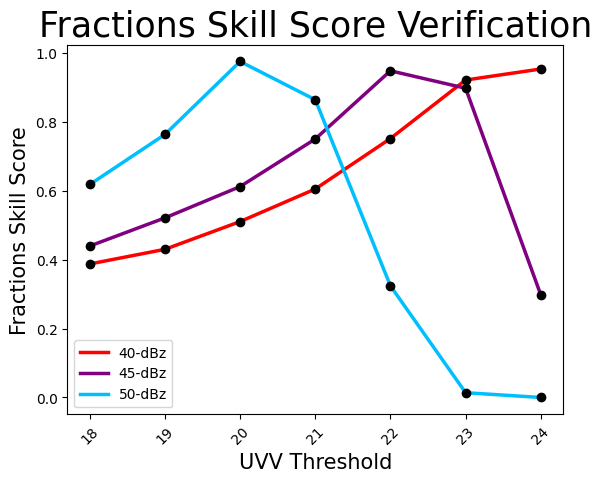

In [19]:
#plot the scores of the FSS
plt.plot(np.arange(1,8,1), df.FSS.values[:7], color = 'red', lw=2.5)
plt.plot(np.arange(1,8,1), df.FSS.values[7:14], color = 'purple', lw=2.5)
plt.plot(np.arange(1,8,1), df.FSS.values[14:], color = 'deepskyblue', lw=2.5)

plt.scatter(np.arange(1,8,1), df.FSS.values[:7], color = 'black', zorder=10)
plt.scatter(np.arange(1,8,1), df.FSS.values[7:14], color = 'black', zorder=10)
plt.scatter(np.arange(1,8,1), df.FSS.values[14:], color = 'black', zorder=10)

plt.title('Fractions Skill Score Verification',fontsize=25)

plt.yticks(ticks = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.xticks(ticks = np.arange(1,8,1), labels = np.arange(18,25,1), rotation=45)

plt.xlabel('UVV Threshold', size = 15)
plt.ylabel('Fractions Skill Score', size = 15)

plt.legend(['40-dBz', '45-dBz', '50-dBz'], loc ='lower left')